NiftyNet provides a ["CRF-RNN" layer](https://github.com/NifTK/NiftyNet/blob/dev/niftynet/layer/crf.py) for image segmentation, following the idea proposed in
[Zheng et al., Conditional Random Fields as Recurrent Neural Networks, ICCV 2015](https://arxiv.org/abs/1502.03240).

Different from many open-source implementations of the method, NiftyNet's version implements the core algorithm [Fast High‐Dimensional Gaussian Filtering](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-8659.2009.01645.x) with Numpy and TensorFlow APIs. One of the advantages is that the layer is ready-to-use -- once these common Python packages are (pip-)installed.

This tutorial demonstrates the basic usage of this layer.

This demo requires two files, a CT image `100_CT.nii` and a 'noisy' logits map `100__niftynet_out.nii.gz`, to be placed in `demo/crf_as_rnn` folder.
The files (~100Mb) can be downloaded from https://www.dropbox.com/s/lf1hvfyvuo9lsc1/demo_prob.tar.gz?dl=1

# CRF inferences
Given a CRF model and some noisy segmentation outputs, model inference is to find the best underlying 'true' segmentation label that minimises CRF's energy.

### Load and visualise the data

In [203]:
import sys
niftynet_path = '/Users/demo/Documents/NiftyNet/'
sys.path.insert(0, niftynet_path)

from niftynet.layer.crf import CRFAsRNNLayer

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [204]:
ct_image = nib.load('100_CT.nii').get_data()
logits = nib.load('100__niftynet_out.nii.gz').get_data()

print('CT image shape: {}'.format(ct_image.shape))
print('Predicted logits shape: {}'.format(logits.shape))

CT image shape: (144, 144, 144)
Predicted logits shape: (144, 144, 144, 1, 9)


The CT volume has 144x144x144 voxels,
the predicted logits has nine channels corresponding
to eight types of organs (plus a channel for background).
As a demo, let's only study a slice of the volume:

In [205]:
slice_idx = 73
ct_slice = np.transpose(ct_image[::-1, ::-1, slice_idx])
ct_logits = np.transpose(logits[::-1, ::-1, slice_idx, 0, :], axes=(1, 0, 2))

print('CT slice shape: {}'.format(ct_slice.shape))
print('Predicted logits shape: {}'.format(ct_logits.shape))

CT slice shape: (144, 144)
Predicted logits shape: (144, 144, 9)


Visualisation of the slice:

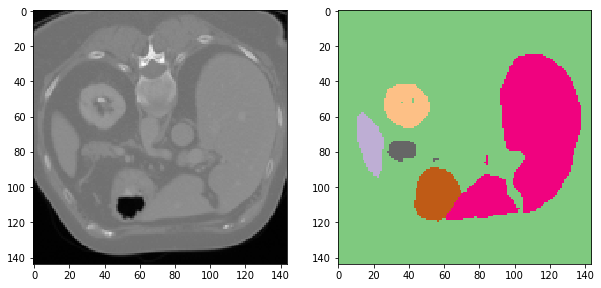

In [206]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(ct_slice, cmap='gray')
axes[1].imshow(np.argmax(ct_logits, -1), cmap='Accent')

### Build the graph and initialise a CRFAsRNNLayer:

CRFAsRNNLayer requires two inputs: 

-- image features `[batch x spatial_dims x n_features]`

-- initial segmentation logits`[batch x spatial_dims x n_classes]`.

In [207]:
# make a tensor with batch size 1 and channel 9
tf_logits = tf.constant(ct_logits, dtype=tf.float32)
tf_logits = tf.expand_dims(tf_logits, axis=0)
print(tf_logits)

# make a tensor of the CT intensity
tf_features = tf.constant(ct_slice, dtype=tf.float32)
tf_features = tf.expand_dims(tf_features, axis=0)
tf_features = tf.expand_dims(tf_features, axis=-1)
print(tf_features)

Tensor("ExpandDims_24:0", shape=(1, 144, 144, 9), dtype=float32)
Tensor("ExpandDims_26:0", shape=(1, 144, 144, 1), dtype=float32)


In [208]:
crf_layer = CRFAsRNNLayer(alpha=160., beta=3., gamma=3., T=5,
                          w_init=[1.0 * np.ones(9), 3.0 * np.ones(9)])
smoothed_logits = crf_layer(tf_features, tf_logits)
smoothed_label = tf.cast(tf.argmax(smoothed_logits, -1), tf.int32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_label = sess.run(smoothed_label)

Let's visualise the outputs:

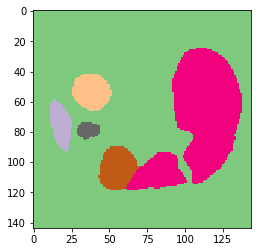

In [209]:
plt.imshow(output_label[0,...], cmap='Accent')

### Effects of weighting of the kernels
The pairwise potential of Dense CRF consists of two kernels:

-- bilateral kernel, encourages nearby pixels with similar features/colours to have the same label.

-- spatial kernel, encourages nearby pixels to have the same label.

To see how they change the final segmentation output, we first define a wrapper to compute the output given specific weights, and then run the layer with different weight combinations.

In [210]:
def varying_w_init(w_bilateral=1.0, w_spatial=3.0):
    crf_layer = CRFAsRNNLayer(alpha=5., beta=5., gamma=3., T=5,
                              w_init=[w_bilateral * np.ones(9), w_spatial * np.ones(9)])
    smoothed_logits = crf_layer(tf_features, tf_logits)
    smoothed_label = tf.cast(tf.argmax(smoothed_logits, -1), tf.int32)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        output_label = sess.run(smoothed_label)
    return output_label[0]

### Visualise the effects of using spatial kernels only

In [211]:
labels = []
w_spatials = [0.0, 1.0, 5.0, 10.0, 100.0, 200.0]
for w_spatial in w_spatials:
    labels.append(varying_w_init(0.0, w_spatial))

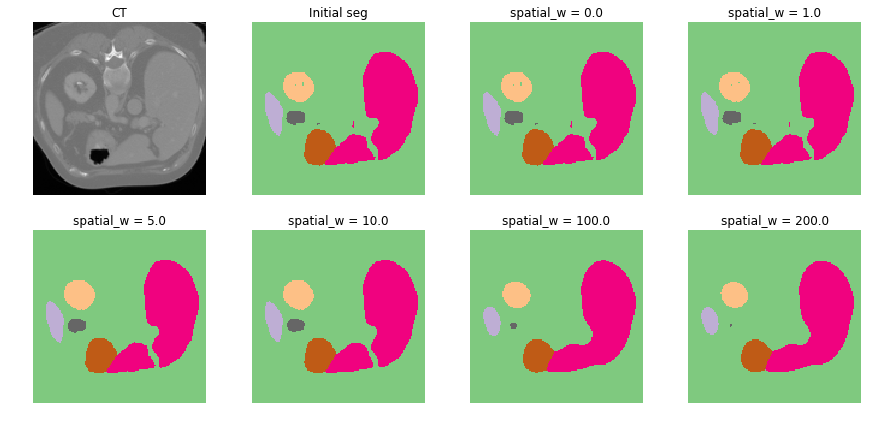

In [212]:
f, axes = plt.subplots(2, 4, figsize=(15,7))
axes[0][0].imshow(ct_slice, cmap='gray'); 
axes[0][0].set_title('CT'); axes[0][0].set_axis_off()
axes[0][1].imshow(np.argmax(ct_logits, -1), cmap='Accent'); 
axes[0][1].set_title('Initial seg'); axes[0][1].set_axis_off()
for idx, label in enumerate(labels):
    i = idx + 2
    c_axes = axes[i//4][i%4]
    c_axes.imshow(label, cmap='Accent'); 
    c_axes.set_title('spatial_w = {}'.format(w_spatials[idx]))
    c_axes.set_axis_off()

### Visualise the effects of using bilateral kernels only

In [213]:
labels = []
w_bilaterals = [0.0, 1.0, 5.0, 10.0, 100.0, 200.0]
for w_bilateral in w_bilaterals:
    labels.append(varying_w_init(w_bilateral, 0.0))

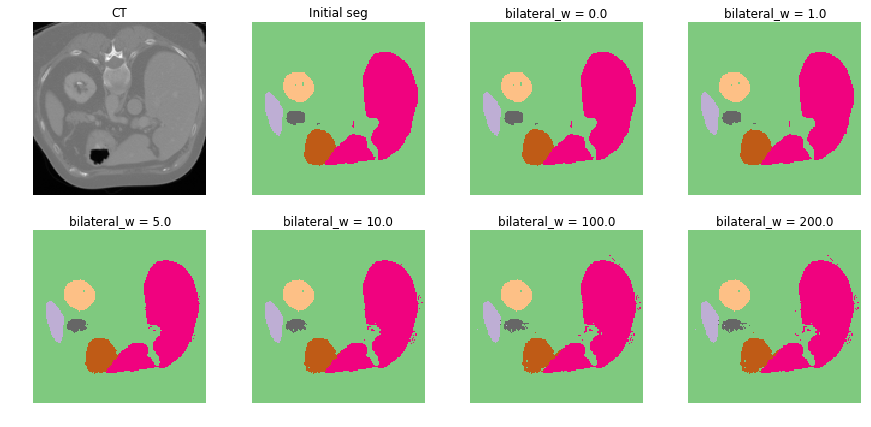

In [214]:
f, axes = plt.subplots(2, 4, figsize=(15,7))
axes[0][0].imshow(ct_slice, cmap='gray'); 
axes[0][0].set_title('CT'); axes[0][0].set_axis_off()
axes[0][1].imshow(np.argmax(ct_logits, -1), cmap='Accent'); 
axes[0][1].set_title('Initial seg'); axes[0][1].set_axis_off()
for idx, label in enumerate(labels):
    i = idx + 2
    c_axes = axes[i//4][i%4]
    c_axes.imshow(label, cmap='Accent'); 
    c_axes.set_title('bilateral_w = {}'.format(w_bilaterals[idx]))
    c_axes.set_axis_off()